In [1]:
# import libraries
from numpy import mean
from numpy import std
from numpy import hstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace all of ? with None
df = df.replace(['?'], [None])
# Drop all rows with None in them
df = df.dropna(axis=0)

# Check no None values remain
df.isnull().sum()

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]
# Workclass, Fnlwgt, Race and Native-country are not worth using.
# Education = Education num, so drop Education
df = df.drop(columns=['Workclass', 'Race', 'Fnlwgt', 'Native-country', 'Education'])

In [2]:
#Numerically encoding occupation: Occupaiton is grouped into white collar and blue collar 
occupation_mapping_dict = {
    "Tech-support" : 0,
    "Craft-repair" : 1, 
    "Other-service" : 1, #Wasn't sure about blue or white collar for other services 
    "Sales" : 0, 
    "Exec-managerial" : 0, 
    "Prof-specialty" : 0, 
    "Handlers-cleaners" : 1, 
    "Machine-op-inspct" : 1, 
    "Adm-clerical" : 0, 
    "Farming-fishing" : 1, 
    "Transport-moving" : 1, 
    "Priv-house-serv" : 1, 
    "Protective-serv" : 1, 
    "Armed-Forces" : 1
    }

df["Occupation"] = df["Occupation"].map(occupation_mapping_dict)


#Numerically encoding the sex variable 
sex_mapping_dict = {
    "Male" : 0,
    "Female" : 1
    }

df["Sex"] = df["Sex"].map(sex_mapping_dict)


#Encoding income variable
income_mapping_dict = {
    "<=50K" : 0,
    ">50K" : 1, 
    "<=50K." : 0, 
    ">50K." : 1
    }

df["Income"] = df["Income"].map(income_mapping_dict)


# FOR MODELS
# Group ages into discrete bins for models
bins = [10,20,30,40,50,60,70,80,90]
names = ['0', '1', '2', '3', '4', '5', '6', '7']
df['Age'] = pd.cut(df['Age'], bins, labels = names)



df

,Age,Education-num,Marital-status,Occupation,Relationship,Sex,Capital-gain,Capital-loss,Hours-per-week,Income
0,6,9,Widowed,0,Other-relative,1,0,0,16,0
1,2,13,Married-civ-spouse,0,Husband,0,0,0,35,0
2,3,11,Divorced,0,Not-in-family,0,0,0,25,0
3,3,13,Divorced,0,Own-child,1,0,0,40,0
4,1,13,Never-married,0,Not-in-family,0,0,0,55,0
...,...,...,...,...,...,...,...,...,...,...
48837,2,7,Married-civ-spouse,1,Husband,0,0,0,40,0
48838,1,4,Never-married,1,Not-in-family,0,0,0,40,0
48839,2,13,Married-civ-spouse,0,Husband,0,0,0,50,1
48840,1,9,Married-civ-spouse,1,Husband,0,0,0,40,0


In [3]:
#Will now employ one-hot encoding for :  Marital Status and Relationship ; no order in their values
df = pd.get_dummies(df, columns = ['Relationship', 'Marital-status'])

In [4]:
df['Capital-gain'].value_counts()
# 229 values have 99,999 which is ALOT. Is this cap value? or error?

0        41432
15024      498
7688       391
7298       351
99999      229
         ...  
7262         1
1731         1
22040        1
1639         1
2387         1
Name: Capital-gain, Length: 121, dtype: int64

In [5]:
# Will now do feature scaling on Capital-gaine and Capital-loss
col_names = ['Capital-gain', 'Capital-loss']
features = df[col_names]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[col_names] = scaler.fit_transform(features.values)
df


,Age,Education-num,Occupation,Sex,Capital-gain,Capital-loss,Hours-per-week,Income,Relationship_Husband,Relationship_Not-in-family,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Marital-status_Divorced,Marital-status_Married-AF-spouse,Marital-status_Married-civ-spouse,Marital-status_Married-spouse-absent,Marital-status_Never-married,Marital-status_Separated,Marital-status_Widowed
0,6,9,0,1,-0.146733,-0.21878,16,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,13,0,0,-0.146733,-0.21878,35,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,3,11,0,0,-0.146733,-0.21878,25,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,3,13,0,1,-0.146733,-0.21878,40,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,1,13,0,0,-0.146733,-0.21878,55,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,2,7,1,0,-0.146733,-0.21878,40,0,1,0,...,0,0,0,0,0,1,0,0,0,0
48838,1,4,1,0,-0.146733,-0.21878,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48839,2,13,0,0,-0.146733,-0.21878,50,1,1,0,...,0,0,0,0,0,1,0,0,0,0
48840,1,9,1,0,-0.146733,-0.21878,40,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
# Converting Age column data from string to numerical.
df[["Age"]] = df[["Age"]].apply(pd.to_numeric)

In [7]:
# Split X and y
X = df.iloc[:, [0,1,2, 3, 4, 5, 6,8,9,10,11,12,13,14,15,16,17,18,19,20]]
y = df.iloc[:, [7]]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.20)

In [8]:
#Import LogisticRegression model
from sklearn.linear_model import LogisticRegression

# {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
# {'C': 0.1, 'max_iter': 4000, 'penalty': 'l2', 'solver': 'liblinear'}
#Defining our model 
# model = LogisticRegression(C=0.1, max_iter=4000, penalty='l2', solver='liblinear')
model = LogisticRegression(max_iter=4000)

model.get_params()


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 4000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [9]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'solver': ['newton-cg', 'liblinear', 'lbfgs','newton-cholesky', 'sag', 'saga'],
#           'penalty': ['l1', 'l2'],
#           'C': [0.1],
#           'max_iter': [4000]
#          }

# # Create a base model
# rf = LogisticRegression()
# # rf = BernoulliNB()


# grid_search = GridSearchCV(estimator=rf, 
#                      param_grid=param_grid, 
#                      cv=3,
#                      n_jobs = -1,
#                      verbose=2, 
#                      return_train_score=True)

In [10]:
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train.ravel())
# grid_search.best_params_

In [11]:
model.fit(X_train, y_train.ravel())

LogisticRegression(max_iter=4000)

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
train_data_predictions = cross_val_predict(model, X_train, y_train.ravel(), cv=20)

In [13]:
print(accuracy_score(y_train, train_data_predictions))

0.8435746468750864


In [14]:
# LogisticRegression(C=0.1, max_iter=4000, penalty='l1', solver='saga')
# 0.8439616330817923

# LogisticRegression(max_iter=4000)
# 0.8426071813583216
# 0.8434364375155485
# 0.842773032589767


# {'C': 0.1, 'max_iter': 4000, 'penalty': 'l2', 'solver': 'liblinear'}
# Uses l2 logistic regression (explain what this is)
# 0.8439339912098848
# 0.8444039030323134
# 0.8449567404704647
# 0.8451225917019101
# 0.8429941675650275

In [15]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


sgd = LogisticRegression()

# param_grid = {
#   'eta0': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#   'learning_rate': ['constant'],
#   'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
# }

param_grid = {'solver': ['newton-cg', 'liblinear', 'lbfgs','newton-cholesky', 'sag', 'saga'],
          'penalty': ['l1', 'l2'],
          'C': [1000, 10, 1, 0.1, 0.001, 0.001],
          'max_iter': [4000]
         }

grid_search = GridSearchCV(sgd, param_grid=param_grid)

grid_search.fit(X_train, y_train.ravel())

result = grid_search.cv_results_
estimator = grid_search.best_estimator_
best_score = grid_search.best_score_
best_params = grid_search.best_params_

mean_scores = result['mean_test_score']

scores_combo = {} # {[alpha_value]: { x: [eta0 values], y: [scores]}}

for idx, param in enumerate(result['params']):
    alpha = param['penalty']
    eta0 = param['C']
    score = mean_scores[idx]
    if scores_combo.get(alpha):
        scores_combo[alpha]['x'].append(eta0)
        scores_combo[alpha]['y'].append(score)
    else:
        scores_combo[alpha] = {'x': [eta0], 'y': [score]}
    

print(mean_scores)
print(scores_combo)
print('best score', best_score)
print('best params', best_params)

for key in scores_combo:
    if key == 0.1 or key == 0.01:
        values = scores_combo[key]
        label = f'penalty={key}'
        plt.scatter(values['x'], values['y'], label=label)
        
plt.title('Learning rate vs. accuracy')
plt.xlabel('C')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

/Users/mattschaefer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mattschaefer/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mattschaefer/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/mattschaefer/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this t

KeyboardInterrupt: 

<ipython-input-29-c736eb395ee2>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','','Man','','','','Woman'])


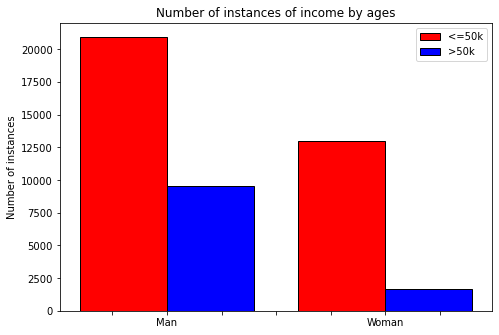

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Created copy of X table and added y column back to XVisual, to allow us to carry out below calculations
XVisual = X
XVisual['y'] = y

Sex = []
lowest = 10
zero = []
one = []
       
# Goes through 
while len(Sex) < 2:
    for i in range(2):
        df_new = XVisual[XVisual['Sex'] == (XVisual['Sex'].value_counts().index.tolist())[i]]
        Sex.append(df_new['Sex'].iloc[0])
        zero.append(df_new['y'].value_counts()[0])
        one.append(df_new['y'].value_counts()[1])
        lowest += 10
            

# # Plots bar chart with zero and one on top of each other
# ind = ['(10-20]', '(20-30]', '(30-40]', '(40-50]', '(50-60]', '(60-70]', '(70-80]', '(80-90]']
# width = 0.9
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.bar(ind, zero, width, color='r', edgecolor = "black")
# ax.bar(ind, one, width, bottom=zero, color='b', edgecolor = "black")
# ax.set_ylabel('Number of instances')
# ax.set_title('Number of instances of income by ages')
# ax.legend(labels=['Zero', 'One'])
# plt.show()

# Plots bar chart with zero and one next to each other
ind = np.arange(len(Sex))
# ind = ['(10-20]', '(20-30]', '(30-40]', '(40-50]', '(50-60]', '(60-70]', '(70-80]', '(80-90]']
width = 0.4
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind-0.2, zero, width, color='r', edgecolor = "black")
ax.bar(ind+0.2, one, width, color='b', edgecolor = "black")
ax.set_ylabel('Number of instances')
ax.set_title('Number of instances of income by ages')
ax.legend(labels=['<=50k', '>50k'])
ax.set_xticklabels(['','','Man','','','','Woman'])
# ax.set_xticklabels(['Man','Woman'])
plt.show()

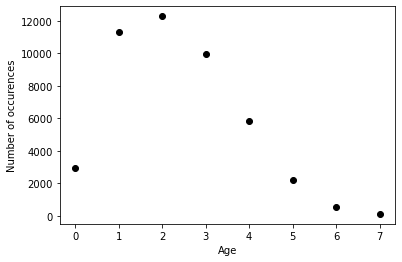

In [ ]:
X['Age'].value_counts().values
X['Age'].value_counts().index.tolist()

# Plotting the number of occurences of each age within the data
plt.scatter(X['Age'].value_counts().index.tolist(), X['Age'].value_counts().values, color='black')
plt.xlabel("Age")
plt.ylabel("Number of occurences")
plt.show()

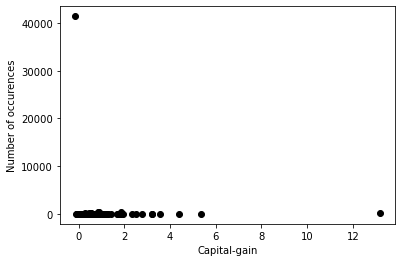